<a href="https://colab.research.google.com/github/pran872/Brain-Network/blob/main/level3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Level 2: Baseline CNN + FL on CIFAR-10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from torch.nn import MaxPool2d, functional as F
from torch import cat

In [2]:
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
# Normalize CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full training set
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split: 45k train / 5k val
train_size = int(0.9 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = random_split(full_train_set, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)

# Test set stays untouched
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 39.8MB/s]


In [5]:
class Flex2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device, stride=1, padding=0, config=None):
        super().__init__()
        """
        # in dimensions: in this case [C, H, W]
        # --------
        # logits_mechanism: THRESHOLD or SPATIAL_ATTENTION_(1-3)
        # masking_mechanism: "SIGMOID", "STE", "SIGMOID_SMOOTHED", "STE_SIGMOID"
        # num_spatial_attention_block: int
        # logits_use_batchnorm: bool

        # about parameter vs variable:
        variable is almost deprecated and works the same as just plain tensor. And a Parameters is a specific Tensor that is marked as being a parameter from an nn.Module and so will be returned when calling .parameters() on this Module.
        """
        # -------- set configs --------
        # assert config, "Missing config file for Flex2D"
        # self.config = config
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.device = device

        # -------- Initialize layers --------
        self.flex_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.flex_pool = MaxPool2d(kernel_size, stride, padding)
        self.bn_logits = nn.BatchNorm2d(self.out_channels)

        # -------- Initialize monitored variables --------
        self.homogeneity = 0  # for monitoring the binariness of the mask later on
        self.conv_ratio = 0  # for later updating
        self.cp_identity_matrix = None  # store the matrix indicating the channel pool identity

    def channel_interpolate(self, tensor, out_channels):
        """
        Interpolates a tensor along the channel axis. This is for addressing the mismatch in the number of channels between the output of the maxpool layer and the output of the convolutional layer.
        """
        tensor = tensor.permute(0, 2, 1, 3)
        tensor = F.interpolate(tensor, [out_channels, tensor.size(3)], mode="bilinear")
        tensor = tensor.permute(0, 2, 1, 3)
        return tensor

    def channel_wise_maxpool(self, tensor_1, tensor_2):
        """
        Take two tensors of identical shape and return a tensor of the same shape using element-wise max pooling.
        Also returns the ratio of values from tensor_2 to the total.
        """
        assert tensor_1.shape == tensor_2.shape, "tensor_1 and tensor_2 must have the same shape"

        joint = cat([tensor_1.unsqueeze(-1), tensor_2.unsqueeze(-1)], dim=-1)
        pooled, indices = torch.max(joint, dim=-1)

        # count values are from conv (tensor 2)
        with torch.no_grad():
            conv_ratio = (indices == 1).sum().item() / tensor_1.numel()
            cp_identity_matrix = (indices == 1).int()

        return pooled, conv_ratio, cp_identity_matrix

    def forward(self, x):
        """
        threshold can only be initialized when the output dimensions are known
        """
        # -------- make the raw conv and pool --------
        t_flex_pool = self.flex_pool(x)
        t_flex_conv = self.flex_conv(x)
        t_flex_pool = self.channel_interpolate(t_flex_pool, self.out_channels)

        # -------- get the binary mask --------
        output, self.conv_ratio, self.cp_identity_matrix = self.channel_wise_maxpool(t_flex_pool, t_flex_conv)
        return output

class CNNWithFlexLayer(nn.Module):
    def __init__(self, device):
        super(CNNWithFlexLayer, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.flex = Flex2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: 16x16x16
        x = self.flex(x)                      # Output: 32x16x16
        x = self.pool(x)                      # Output: 32x8x8
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNNWithFlexLayer(device).to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [7]:
def train_model(epochs=5):
    for epoch in range(epochs):
        print("")
        start = time.time()
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        end = time.time()
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}% | "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% | Time: {end - start:.2f}s")


In [8]:
train_model(epochs=10)


Epoch 1 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Epoch 1: Train Loss=1.7158, Train Acc=38.51% | Val Loss=1.4581, Val Acc=48.66% | Time: 61.94s



Epoch 2 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Epoch 2: Train Loss=1.3668, Train Acc=51.71% | Val Loss=1.3110, Val Acc=54.20% | Time: 63.30s



Epoch 3 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 3: Train Loss=1.2693, Train Acc=55.34% | Val Loss=1.2671, Val Acc=55.08% | Time: 63.48s



Epoch 4 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Epoch 4: Train Loss=1.2070, Train Acc=57.57% | Val Loss=1.2096, Val Acc=58.36% | Time: 62.76s



Epoch 5 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Epoch 5: Train Loss=1.1471, Train Acc=59.95% | Val Loss=1.1513, Val Acc=60.12% | Time: 63.11s



Epoch 6 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Epoch 6: Train Loss=1.0979, Train Acc=61.41% | Val Loss=1.1066, Val Acc=61.54% | Time: 60.91s



Epoch 7 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Epoch 7: Train Loss=1.0573, Train Acc=62.77% | Val Loss=1.0562, Val Acc=63.84% | Time: 62.81s



Epoch 8 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Epoch 8: Train Loss=1.0210, Train Acc=64.15% | Val Loss=1.0456, Val Acc=63.50% | Time: 65.90s



Epoch 9 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


Epoch 9: Train Loss=0.9999, Train Acc=65.03% | Val Loss=1.0195, Val Acc=65.20% | Time: 64.03s



Epoch 10 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]

Epoch 10: Train Loss=0.9638, Train Acc=66.30% | Val Loss=0.9916, Val Acc=65.96% | Time: 63.52s


In [9]:
def test_model():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test_model()


Testing: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s]

Test Accuracy: 66.09%


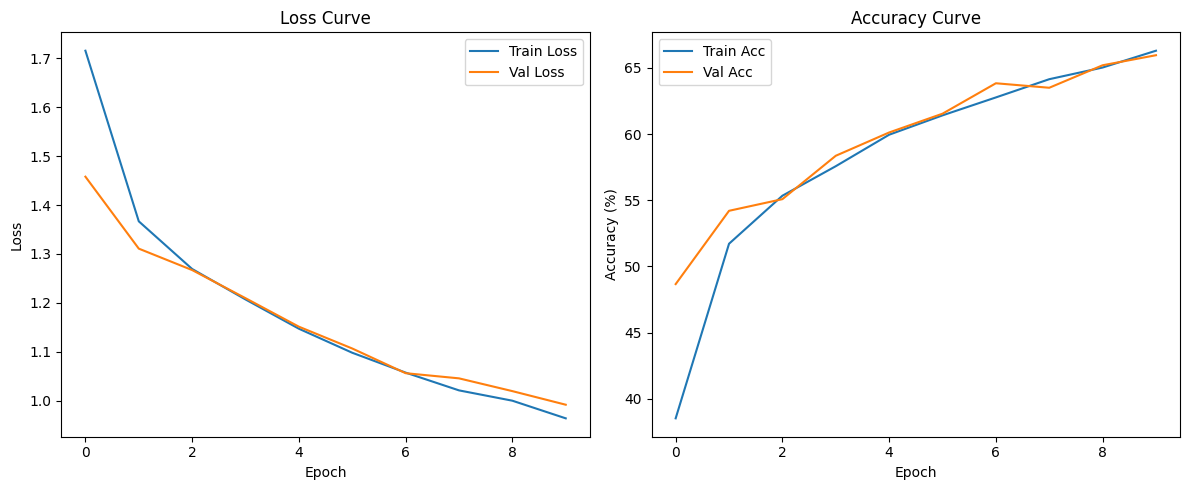

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
